In [1]:
!pip install tensorflow==2.15
!pip install qutip==4.7.6

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installatio

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
import os
import sys
import csv
import math
import time
import re
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
#from keras.layers.preprocessing import preprocessing_utils

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/sdes')
import sde_solve
import sde_systems
import data_gen

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/systems')
import rabi_weak_meas

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models')
import fusion
import flex
import train

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models/test')
import test_fusion

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [5]:
import imp
imp.reload(fusion)
imp.reload(flex)
imp.reload(train)
imp.reload(sde_systems)
imp.reload(data_gen)
imp.reload(sde_solve)
imp.reload(test_fusion)

<module 'test_fusion' from '/content/gdrive/MyDrive/git/quantumML/python/models/test/test_fusion.py'>

In [6]:
tf.__version__

'2.15.0'

In [7]:
import qutip as qt

In [9]:
tol = 1e-2

mint = 0.0
maxt = 1.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)

omega = 1.395
kappa = 4.0*0.83156
eta = 0.1469
gamma_s = 0.0
epsilons = np.arange(0.0, 2.01, 0.5)
num_traj=100
meas_op = [0,1]
input_params = [4]

sx, sy, _ = sde_systems.paulis()
rho0 = sde_systems.get_init_rho(sx, sy, 0, 0)[tf.newaxis,...]

r2d_out = None
qutip_out = None
for eps in epsilons:
    print(f'epsilon = {eps}')

    # Run QuTiP
    sx0 = qt.tensor(qt.sigmax(), qt.identity(2))
    sx1 = qt.tensor(qt.identity(2), qt.sigmax())
    sy0 = qt.tensor(qt.sigmay(), qt.identity(2))
    sy1 = qt.tensor(qt.identity(2), qt.sigmay())
    sz0 = qt.tensor(qt.sigmaz(), qt.identity(2))
    sz1 = qt.tensor(qt.identity(2), qt.sigmaz())
    szz = qt.tensor(qt.sigmaz(), qt.sigmaz())

    H = 0.5*omega*(sx0 + sx1) + eps*szz

    xup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + qt.basis(2,1))
    yup = (1.0/np.sqrt(2.0))*(qt.basis(2,0) + 1j*qt.basis(2,1))
    psi0 = qt.tensor(xup, yup)
    qtrho0 = psi0*psi0.dag()

    result = qt.smesolve(H, qtrho0, tvec,
                        c_ops=[np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sx0, np.sqrt(1.0 - 0.5*eta)*np.sqrt(kappa) * sy1],
                        sc_ops=[np.sqrt(0.5*eta*kappa) * sx0, np.sqrt(0.5*eta*kappa) * sy1],
                        e_ops=[sx0,sx1,sy0,sy1,sz0,sz1],
                        ntraj=num_traj,
                        dW_factors=[1,1],
                        solver='euler',
                        store_measurement=True,
                        noise=1)

    qt_noise = np.array(result.noise)
    wvec = qt_noise[...,0,:,tf.newaxis]

    # Run the model
    epsilons_traj = tf.repeat([eps], repeats=num_traj, axis=0)[:,tf.newaxis]
    params = np.array([omega,2.0*kappa,eta,gamma_s,eps], dtype=np.float32)
    for ii in range(params.shape[0]):
        if ii in input_params:
            param_idx = input_params.index(ii)
            param_inputs = epsilons_traj[:,param_idx:param_idx+1]
        else:
            param_inputs = params[ii]*np.ones_like(epsilons_traj[:,:1])

        if ii == 0:
            traj_inputs = param_inputs
        else:
            traj_inputs = tf.concat([traj_inputs, param_inputs], axis=1)

    meas_op0 = tf.one_hot([meas_op[0]], depth=3)*tf.ones([num_traj,3], tf.float32)
    meas_op1 = tf.one_hot([meas_op[1]], depth=3)*tf.ones([num_traj,3], tf.float32)
    traj_inputs = tf.concat([tf.cast(traj_inputs, tf.float32), meas_op0, meas_op1], axis=1)

    t0 = time.time()
    print('Running run_model_2d...')
    rhovec, ivec, _, _ = fusion.run_model_2d(rho0, traj_inputs, num_traj=num_traj, mint=mint, maxt=maxt, deltat=deltat, sim_noise=True, comp_i=True, wvec=wvec)
    print(f'Done. Run time (s): {time.time() - t0}')
    probs = sde_systems.get_2d_probs(rhovec)

    # Compare trajectories relative to the mean
    all_meas = np.zeros([len(result.measurement), result.measurement[0].shape[0], result.measurement[0].shape[1]], result.measurement[0].dtype)
    for idx in range(len(result.measurement)):
        all_meas[idx,:,:] = result.measurement[idx]
    #qutip_diff = tf.reshape(all_meas, [-1,1,all_meas.shape[1], all_meas.shape[2]])
    #qutip_diff = tf.reduce_mean(qutip_diff, axis=1)

    qutip_volt = test_fusion.diff_to_volt(tf.constant(all_meas), deltat)[:,:-1,:]

    rel_err = tf.reduce_mean(tf.abs(ivec[:,20:,:] - qutip_volt[:,20:,:])/tf.abs(tf.reduce_mean(qutip_volt[:,20:,:], axis=0)))
    print(f'Rel ERR: {rel_err}')
    assert(rel_err <= tol)

    if r2d_out is None:
      r2d_out = ivec
      qutip_out = qutip_volt
    else:
      r2d_out = tf.concat([r2d_out, ivec], axis=0)
      qutip_out = tf.concat([qutip_out, qutip_volt], axis=0)

epsilon = 0.0
10.0%. Run time:   0.02s. Est. time left: 00:00:00:00
20.0%. Run time:   0.05s. Est. time left: 00:00:00:00
30.0%. Run time:   0.08s. Est. time left: 00:00:00:00
40.0%. Run time:   0.10s. Est. time left: 00:00:00:00
50.0%. Run time:   0.13s. Est. time left: 00:00:00:00
60.0%. Run time:   0.16s. Est. time left: 00:00:00:00
70.0%. Run time:   0.18s. Est. time left: 00:00:00:00
80.0%. Run time:   0.21s. Est. time left: 00:00:00:00
90.0%. Run time:   0.24s. Est. time left: 00:00:00:00
Total run time:   0.27s
Running run_model_2d...
Start rho 2
l48 t =  0.0
l48 t =  0.0390625
l48 t =  0.078125
l48 t =  0.1171875
l48 t =  0.15625
l48 t =  0.1953125
l48 t =  0.234375
l48 t =  0.2734375
l48 t =  0.3125
l48 t =  0.3515625
l48 t =  0.390625
l48 t =  0.4296875
l48 t =  0.46875
l48 t =  0.5078125
l48 t =  0.546875
l48 t =  0.5859375
l48 t =  0.625
l48 t =  0.6640625
l48 t =  0.703125
l48 t =  0.7421875
l48 t =  0.78125
l48 t =  0.8203125
l48 t =  0.859375
l48 t =  0.8984375
l48 t =  

In [10]:
r2d_out.shape

TensorShape([500, 256, 2])

In [11]:
qutip_out.shape

TensorShape([500, 256, 2])

In [12]:
all_params_traj = tf.repeat(epsilons, repeats=num_traj, axis=0)[:,tf.newaxis]
all_params_traj.shape

TensorShape([500, 1])

In [13]:
assert(tf.reduce_max(tf.abs(tf.math.imag(r2d_out))) < 1.0e-14)
r2d_out = tf.math.real(r2d_out)

In [14]:
assert(tf.reduce_max(tf.abs(tf.math.imag(qutip_out))) < 1.0e-14)
qutip_out = tf.math.real(qutip_out)

In [17]:
for paramidx in range(all_params_traj.shape[0]):
    eps = all_params_traj[paramidx,0].numpy()
    print(f'Checking (epsilon) =({eps})...')

    mses = tf.reduce_mean(tf.square(r2d_out[paramidx,:,:] - qutip_out[paramidx,:,:]), axis=0)
    max_mse = tf.reduce_max(mses)
    print(f'Max MSE:{max_mse}, mse shape = {mses.shape}' )
    assert(max_mse <= 1.0e-4)

Checking (epsilon) =(0.0)...
Max MSE:5.222275640779059e-06, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:1.0640694047350958e-07, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:8.854833845610018e-07, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:9.006576982960639e-08, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:2.2075833879699512e-07, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:4.285473825390979e-07, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:2.3895924706600946e-08, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:4.699569304493816e-07, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:1.0268995015161998e-07, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:6.289583144627215e-07, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:4.8699089350999995e-08, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:9.43675459743414e-06, mse shape = (2,)
Checking (epsilon) =(0.0)...
Max MSE:4.585484314527582e-07, mse shape = 

In [18]:
mses = tf.reduce_mean(tf.square(r2d_out - qutip_out), axis=1)
max_mse = tf.reduce_max(mses)
print(f'Max MSE:{max_mse}, mse shape = {mses.shape}' )

Max MSE:2.6934284585125485e-05, mse shape = (500, 2)


In [19]:
max_abs = tf.reduce_max(tf.abs(r2d_out - qutip_out))
print(f'Max ABS:{max_abs}' )

Max ABS:0.007635718473766984


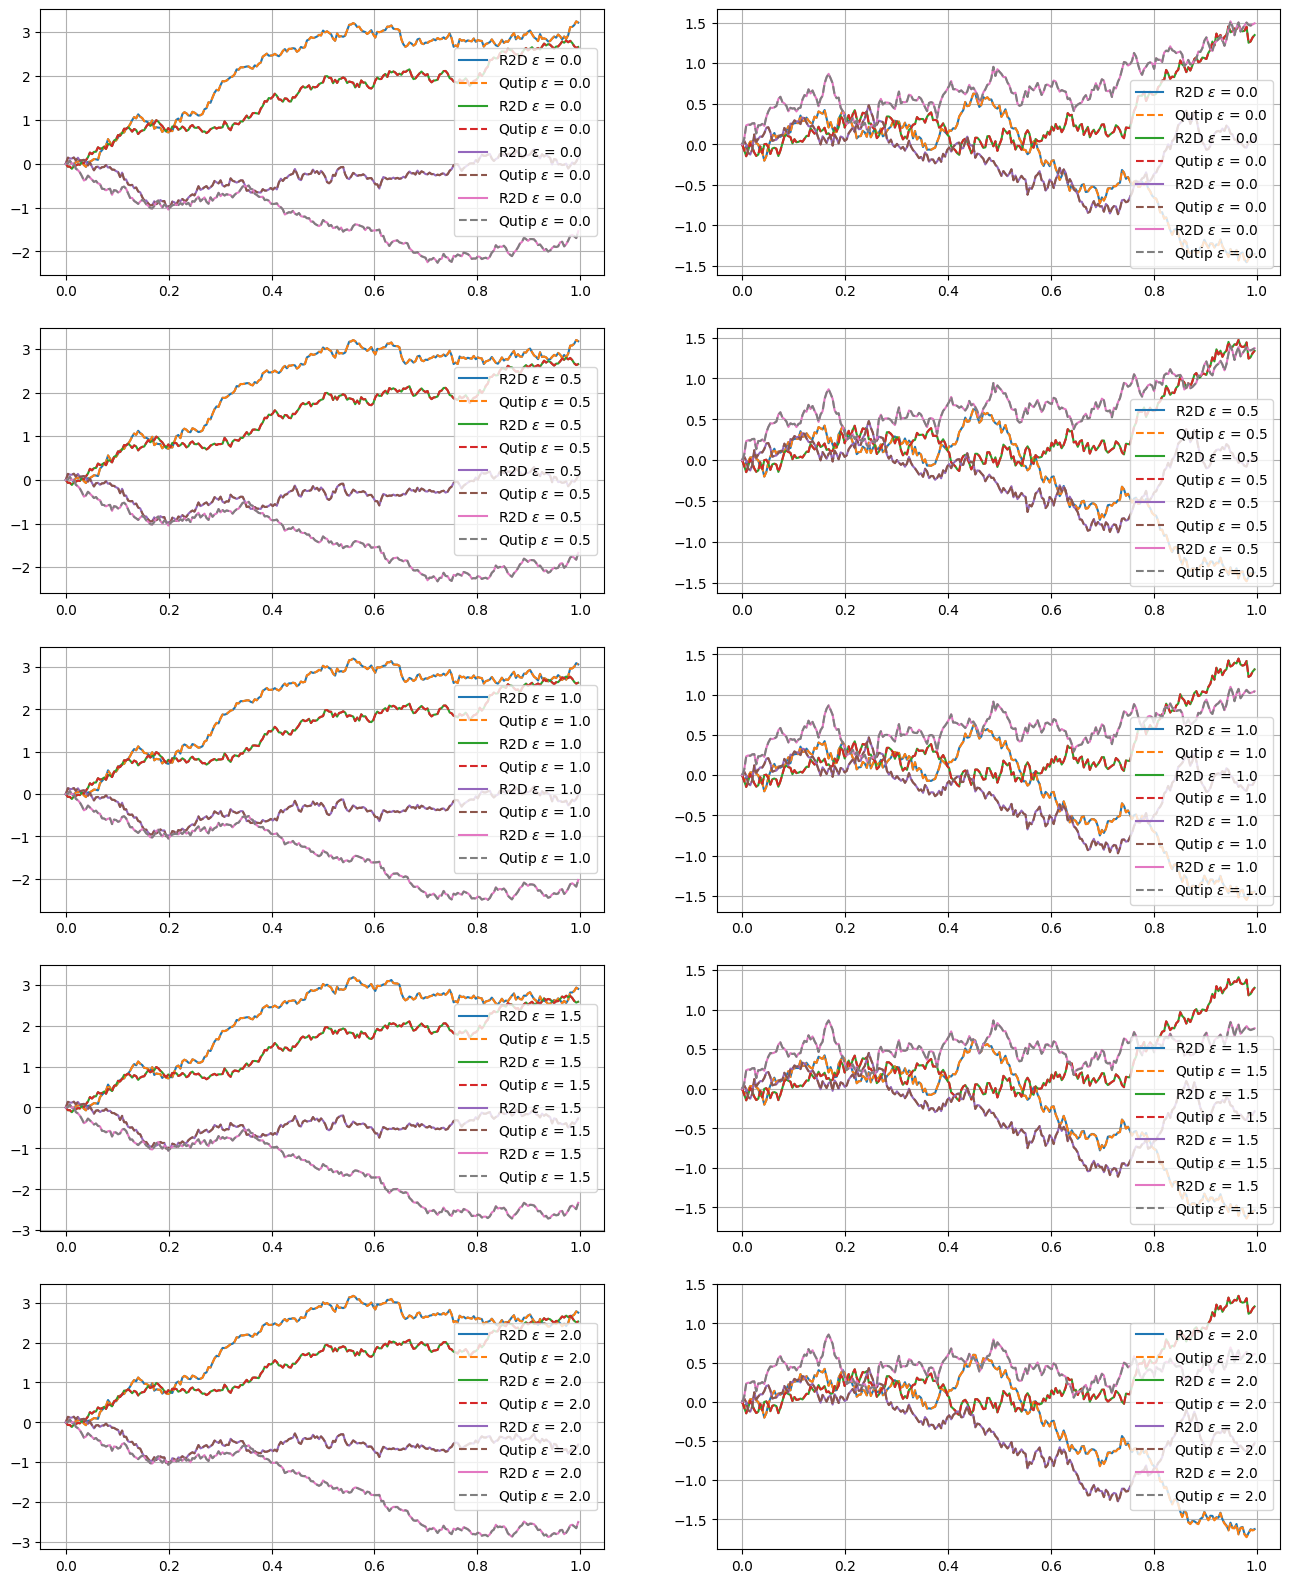

In [20]:
plt.figure(figsize=(16,20))
plot_traj = 4
plotidx = 1
for epsidx in range(0,epsilons.shape[0],1):
  for qidx in range(2):
    plt.subplot(5,2,plotidx)

    for trajidx in range(plot_traj):
      idx = epsidx*num_traj+trajidx
      eps = all_params_traj[idx,0].numpy()
      plt.plot(tvec, r2d_out[idx,:,qidx], label=f'R2D $\epsilon$ = {eps}')
      plt.plot(tvec, qutip_out[idx,:,qidx], '--', label=f'Qutip $\epsilon$ = {eps}')

    plt.legend()
    plt.grid();
    plotidx += 1

In [23]:
abs_errs = tf.reduce_max(tf.abs(r2d_out - qutip_out), axis=1)
print(f'Max ERR:{tf.reduce_max(abs_errs, axis=0)}, mse shape = {abs_errs.shape}' )

Max ERR:[0.00760642 0.00763572], mse shape = (500, 2)


In [24]:
maxidx = tf.argmax(abs_errs[:,0]).numpy()
print(maxidx, abs_errs[maxidx,:])

486 tf.Tensor([0.00760642 0.00759622], shape=(2,), dtype=float64)


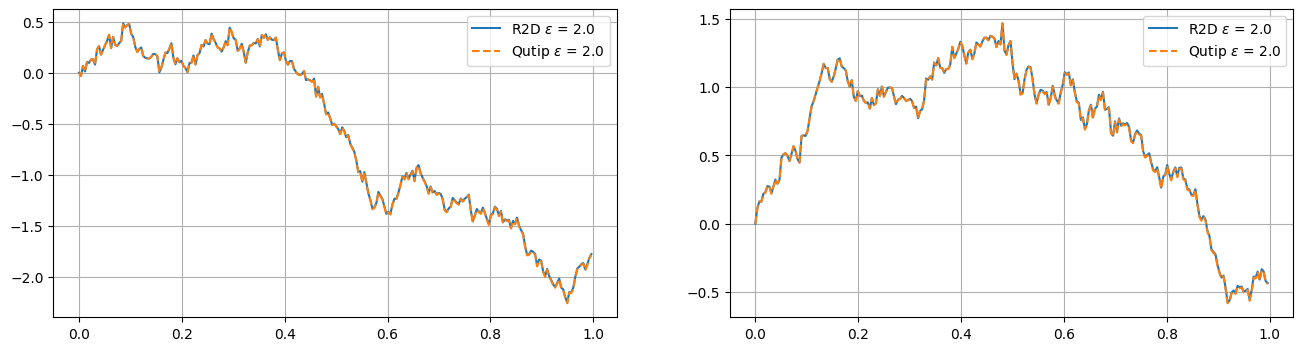

In [45]:
plt.figure(figsize=(16,4))
plotidx = 1
for qidx in range(2):
  plt.subplot(1,2,qidx+1)

  eps = all_params_traj[maxidx,0].numpy()
  plt.plot(tvec, r2d_out[maxidx,:,qidx], label=f'R2D $\epsilon$ = {eps}')
  plt.plot(tvec, qutip_out[maxidx,:,qidx], '--', label=f'Qutip $\epsilon$ = {eps}')

  plt.legend()
  plt.grid();

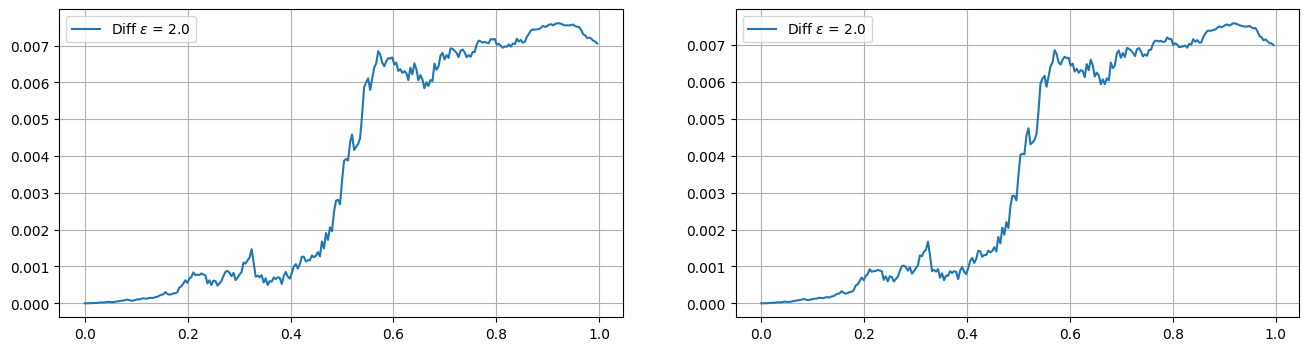

In [46]:
plt.figure(figsize=(16,4))
plotidx = 1
for qidx in range(2):
  plt.subplot(1,2,qidx+1)

  eps = all_params_traj[maxidx,0].numpy()
  plt.plot(tvec, r2d_out[maxidx,:,qidx] - qutip_out[maxidx,:,qidx], label=f'Diff $\epsilon$ = {eps}')

  plt.legend()
  plt.grid();

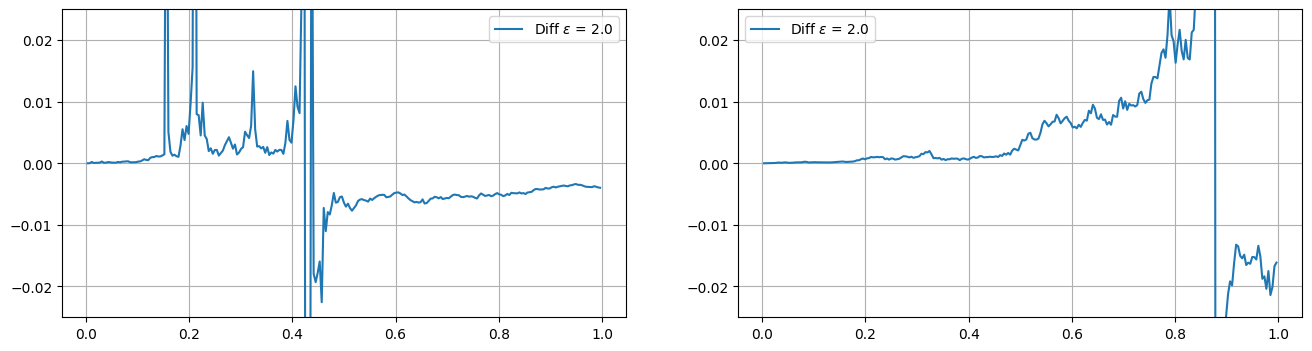

In [47]:
plt.figure(figsize=(16,4))
plotidx = 1
for qidx in range(2):
  plt.subplot(1,2,qidx+1)

  eps = all_params_traj[maxidx,0].numpy()
  plt.plot(tvec, (r2d_out[maxidx,:,qidx] - qutip_out[maxidx,:,qidx])/r2d_out[maxidx,:,qidx], label=f'Diff $\epsilon$ = {eps}')

  plt.ylim([-2.5e-2, 2.5e-2])
  plt.legend()
  plt.grid();

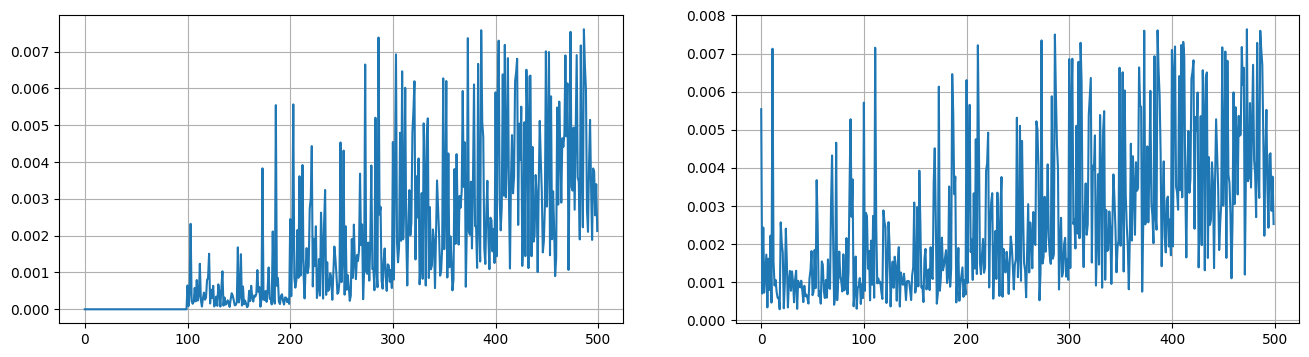

In [48]:
plt.figure(figsize=(16,4))
for qidx in range(2):
  plt.subplot(1,2,qidx+1)
  plt.plot(abs_errs[:,qidx])
  plt.grid();

In [49]:
abs_errs[:,0]

<tf.Tensor: shape=(500,), dtype=float64, numpy=
array([9.65556035e-09, 9.65556435e-09, 9.65556710e-09, 9.65556457e-09,
       9.65556612e-09, 9.65556546e-09, 9.65556421e-09, 9.65556524e-09,
       9.65556446e-09, 9.65556360e-09, 9.65556468e-09, 9.65556213e-09,
       9.65556562e-09, 9.65556479e-09, 9.65556479e-09, 9.65556440e-09,
       9.65556446e-09, 9.65556507e-09, 9.65556290e-09, 9.65556590e-09,
       9.65556524e-09, 9.65556471e-09, 9.65556457e-09, 9.65556524e-09,
       9.65556479e-09, 9.65556457e-09, 9.65556435e-09, 9.65556302e-09,
       9.65556518e-09, 9.65556435e-09, 9.65556501e-09, 9.65556679e-09,
       9.65556590e-09, 9.65556435e-09, 9.65556524e-09, 9.65556457e-09,
       9.65556357e-09, 9.65556368e-09, 9.65556590e-09, 9.65556590e-09,
       9.65556568e-09, 9.65556701e-09, 9.65556413e-09, 9.65556497e-09,
       9.65555902e-09, 9.65556546e-09, 9.65556435e-09, 9.65556479e-09,
       9.65556324e-09, 9.65556546e-09, 9.65556579e-09, 9.65556346e-09,
       9.65556346e-09, 9.6555

In [50]:
r2d_out[maxidx,:10,qidx] - qutip_out[maxidx,:10,qidx]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([0.00000000e+00, 3.78649612e-11, 1.05750435e-06, 3.10390368e-06,
       5.29466105e-06, 8.86302499e-06, 1.20959198e-05, 1.72667624e-05,
       2.65533853e-05, 2.44639806e-05])>

In [51]:
(r2d_out[maxidx,:10,qidx] - qutip_out[maxidx,:10,qidx])/r2d_out[maxidx,:10,qidx]

<tf.Tensor: shape=(10,), dtype=float64, numpy=
array([           nan, 3.33134635e-10, 6.48920290e-06, 1.91631223e-05,
       2.42756710e-05, 3.87476432e-05, 4.39664629e-05, 6.35429064e-05,
       1.19941610e-04, 8.97864385e-05])>

In [52]:
import datetime
print(datetime.datetime.now())

2024-11-03 00:40:04.223738
